# Data preparation

In [1]:
import sys
sys.path.append('../src/')
from data_configuration import configure_KPA_2021_shared_task

Generation of training dataset

In [5]:
args_path = '../kpm_data/arguments_train.csv'
kps_path = '../kpm_data/key_points_train.csv'
labels_path = '../kpm_data/labels_train.csv'
type_name='train'

configure_KPA_2021_shared_task(args_path, kps_path, labels_path, type_name, neg_value=0.5)

Generation of dev dataset

In [6]:
args_path = '../kpm_data/arguments_dev.csv'
kps_path = '../kpm_data/key_points_dev.csv'
labels_path = '../kpm_data/labels_dev.csv'
type_name='dev'

configure_KPA_2021_shared_task(args_path, kps_path, labels_path, type_name, neg_value=0.5)

# Data analysis 

In [7]:
import pandas as pd
from transformers import BertTokenizer
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
# read the data from original datasets provided in the github repo for the task
df_arguments_train = pd.read_csv('../kpm_data/arguments_train.csv')[['arg_id', 'argument']]
df_key_points_train = pd.read_csv('../kpm_data/key_points_train.csv')[['key_point_id', 'key_point']]
df_labels_train = pd.read_csv('../kpm_data/labels_train.csv')

df_arguments_dev = pd.read_csv('../kpm_data/arguments_dev.csv')[['arg_id', 'argument']]
df_key_points_dev = pd.read_csv('../kpm_data/key_points_dev.csv')[['key_point_id', 'key_point']]
df_labels_dev = pd.read_csv('../kpm_data/labels_dev.csv')

Number of args / kps in datsets

In [9]:
print(
f' we have \n \
  {len( df_arguments_train )} training arguments, \n \
  {len( df_arguments_dev )} dev arguments,\n \
  {len( df_arguments_train ) + len( df_arguments_dev )} total arguments. \n \
    \n \
  {len( df_key_points_train )} training key_points, \n \
  {len( df_key_points_dev )} dev key_points,\n \
  {len( df_key_points_train ) + len( df_key_points_dev )} total key_points. '
)

 we have 
   5583 training arguments, 
   932 dev arguments,
   6515 total arguments. 
     
   207 training key_points, 
   36 dev key_points,
   243 total key_points. 


Statistics on lenght of sentences

In [10]:
d = pd.concat( [pd.DataFrame( ),
 df_arguments_dev['argument'].map(lambda x: len(x)).describe().to_frame().T,
 df_arguments_train['argument'].map(lambda x: len(x)).describe().to_frame().T,
 df_key_points_dev['key_point'].map(lambda x: len(x)).describe().to_frame().T,
 df_key_points_train['key_point'].map(lambda x: len(x)).describe().to_frame().T,])
d['index'] = ['arguments_train','arguments_dev','key_points_train','key_points_dev']
d.columns = ['count', 'mean lenght', 'std deviation lenght', 'min lenght', '25%', '50%', '75%', 'max', 'index']
d.set_index('index')

,count,mean lenght,std deviation lenght,min lenght,25%,50%,75%,max
index,,,,,,,,
arguments_train,932.0,110.171674,42.420388,36.0,77.0,103.0,138.0,227.0
arguments_dev,5583.0,110.741358,42.542870,34.0,78.0,105.0,139.0,244.0
key_points_train,36.0,41.250000,11.405199,24.0,32.5,39.5,54.0,60.0
key_points_dev,207.0,52.164251,17.595842,17.0,40.0,49.0,63.0,116.0


Number of elements in datasets

In [11]:
print(
f' we have \n \
  {len( df_labels_train )} training samples, \n \
  {len( df_labels_dev )} dev samples,\n \
  {len( df_labels_train ) + len( df_labels_dev )} total samples. \n \
  '
)

 we have 
   20635 training samples, 
   3458 dev samples,
   24093 total samples. 
   


Barplot positive and negative distribution

 on train set we have 
 20635 training samples, 
 16375 negative samples 
 4260 positive samples 
 26.01526717557252% positive 

 on dev set 
 3458 dev samples,
 2720 negative samples 
 738 positive samples 
 27.132352941176467% positive 


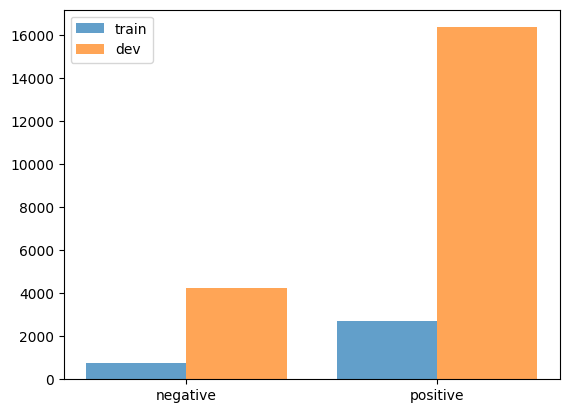

In [12]:
print(f' on train set we have \n \
{len( df_labels_train )} training samples, \n \
{sum(df_labels_train["label"] == 0)} negative samples \n \
{sum(df_labels_train["label"] == 1)} positive samples \n \
{(sum(df_labels_train["label"] == 1)/ sum(df_labels_train["label"] == 0))*100}% positive ')

print()

print(f' on dev set \n \
{len( df_labels_dev )} dev samples,\n \
{sum(df_labels_dev["label"] == 0)} negative samples \n \
{sum(df_labels_dev["label"] == 1)} positive samples \n \
{(sum(df_labels_dev["label"] == 1)/ sum(df_labels_dev["label"] == 0))*100}% positive ')

import matplotlib.pyplot as plt
import numpy as np

# compute numbers to plot
s1_train = sum(df_labels_dev['label']==1)
s1_dev = sum(df_labels_train['label']==1)

s0_train = sum(df_labels_dev['label']==0)
s0_dev = sum(df_labels_train['label']==0)

# assemble vectors to plot
train_bar = [s1_train,s0_train]
dev_bar = [s1_dev,s0_dev]

ind = np.array([.5,1]) # this is .5 bc otherwise bars are two spaced
width = .2 # this is widht of the bars

# index has to be translated
fig, ax = plt.subplots()
ax.bar(ind-(width/2),train_bar,width,alpha=.7,label='train')
ax.bar(ind+(width/2),dev_bar,width,alpha=.7,label='dev')
plt.xticks(ind, labels=['negative','positive'])
plt.legend()

Analysis on tokens lenght

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# per calcolare max len
# max(list(map(lambda x:len(x), args))) , max(list(map(lambda x:len(x), kps)))
MAX_LEN = 250
tokenized_args_train = tokenizer(df_arguments_train['argument'].tolist(), max_length=MAX_LEN, return_tensors='tf', padding='max_length')
tokenized_kps_train = tokenizer(df_key_points_train['key_point'].tolist(), max_length=MAX_LEN, return_tensors='tf', padding='max_length')

tokenized_args_dev = tokenizer(df_arguments_dev['argument'].tolist(), max_length=MAX_LEN, return_tensors='tf', padding='max_length')
tokenized_kps_dev = tokenizer(df_key_points_dev['key_point'].tolist(), max_length=MAX_LEN, return_tensors='tf', padding='max_length')

2022-12-03 11:23:43.353983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-03 11:23:43.354636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [14]:
pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_args_train['input_ids'])) ).describe()

d = pd.concat( [pd.DataFrame( ),
 pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_args_train['input_ids'])) ).describe().to_frame().T,
 pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_args_dev['input_ids'])) ).describe().to_frame().T,
 pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_kps_train['input_ids'])) ).describe().to_frame().T,
 pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_kps_dev['input_ids'])) ).describe().to_frame().T,
])

Boxplot lengths of tokens

<AxesSubplot: >

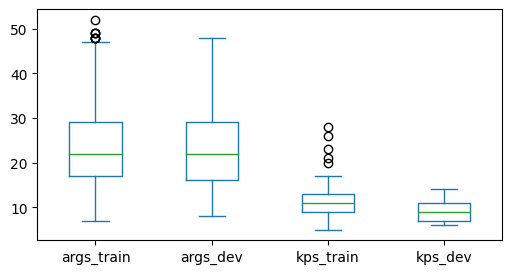

In [15]:
plt.rcParams["figure.figsize"] = (6,3)
pd.DataFrame(
  {
  'args_train':  pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_args_train['input_ids'])) ) ,
  'args_dev':  pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_args_dev['input_ids'])) ) ,
  'kps_train':  pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_kps_train['input_ids'])) ) ,
  'kps_dev':  pd.Series( list(map(lambda x: tf.math.count_nonzero(x).numpy(), tokenized_kps_dev['input_ids'])) ) ,
  }
).plot(kind='box')